In [1]:
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_input, train_target, train_classes, test_input, test_target, test_classes  = prologue.generate_pair_sets(1000)
print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())
print(train_input[:,1].size(), train_target.size())

train_input torch.Size([1000, 2, 14, 14]) train_target torch.Size([1000])
test_input torch.Size([1000, 2, 14, 14]) test_target torch.Size([1000])
torch.Size([1000, 14, 14]) torch.Size([1000])


# Get the dataset

In [20]:
train_input, train_target, test_input, test_target  = prologue.load_data(cifar=False, one_hot_labels=True,
                                                                         normalize=False, flatten=False)
print(train_input.narrow(0, 1, 50).size())
print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
torch.Size([50, 1, 28, 28])
train_input torch.Size([1000, 1, 28, 28]) train_target torch.Size([1000, 10])
test_input torch.Size([1000, 1, 28, 28]) test_target torch.Size([1000, 10])


# Model

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*2*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 1)
        self.MaxPool2d = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout()
        
        
    def forward(self, x, y):
        x = self.MaxPool2d(F.relu(self.conv1(x)))
        x = self.MaxPool2d(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        y = self.MaxPool2d(F.relu(self.conv1(y)))
        y = self.MaxPool2d(F.relu(self.conv2(y)))
        y = y.view(y.size(0), -1)
        z = torch.cat((x,y), 1)
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = self.dropout(z)
        z = F.sigmoid(self.fc4(z))
        return z

# Training

In [29]:
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0
    batch_size = 50
    for b in range(0, data_input.size(0), batch_size):
        output = model(data_input[b:b+batch_size,0].reshape((batch_size, 1, 14, 14)), 
                       data_input[b:b+batch_size,1].reshape((batch_size, 1, 14, 14)))
        output[output>0.5] = 1
        output[output<=0.5] = 0
        #print(predicted_label)
        for k in range(batch_size):
            if output[k] != data_target[b+k]:
                nb_data_errors += 1

    
    return nb_data_errors

In [30]:
batch_size = 100
eta = 0.4
epochs = 250
def train_model(model, train_input, train_target, test_input, test_target):
    
    criterion = nn.BCELoss(size_average=True)
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    
    mu, std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    test_input.sub_(mu).div_(std)
    
    for i in range(epochs):
        model.train(True)
        #batch_1 = np.arange(1000)
        #batch_2 = np.arange(1000)
        #np.random.shuffle(batch_1)
        #np.random.shuffle(batch_2)
        for b in range(0, train_input.size(0), batch_size):
        
            #output = model(train_input.narrow(0, b, batch_size), train_input.narrow(0, c, batch_size))
            output = model(train_input[b:b+batch_size,0].reshape((batch_size, 1, 14, 14)), 
                           train_input[b:b+batch_size,1].reshape((batch_size, 1, 14, 14)))
        #output = model(train_input[batch_1[:50]], train_input[batch_2[:50]])
            
        #        true_labels[train_target.narrow(0, b, batch_size).argmax(1) > train_target.narrow(0, c, batch_size).argmax(1)] = 1
            
            loss = criterion(output, train_target[b:b+batch_size].float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(loss)   
        model.train(False)
        test_accuracy = compute_nb_errors(model, test_input, test_target)
        train_accuracy = compute_nb_errors(model, train_input, train_target)
        print("Epoch #", i, "train accuracy: ", train_accuracy, " test accuracy: ", test_accuracy)

In [31]:
net = Net()
train_model(net, train_input, train_target, test_input, test_target)

tensor(0.6838, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 0 train accuracy:  449  test accuracy:  474
tensor(0.6625, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 1 train accuracy:  344  test accuracy:  386
tensor(0.6109, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 2 train accuracy:  259  test accuracy:  250
tensor(0.4723, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 3 train accuracy:  231  test accuracy:  212
tensor(0.4336, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 4 train accuracy:  193  test accuracy:  203
tensor(0.3941, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 5 train accuracy:  180  test accuracy:  194
tensor(0.4596, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 6 train accuracy:  201  test accuracy:  210
tensor(0.4888, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 7 train accuracy:  186  test accuracy:  206
tensor(0.4852, grad_fn=<BinaryCrossEntropyBackward>)
Epoch # 8 train accuracy:  155  test accuracy:  187
tensor(0.3479, grad_fn=<BinaryCrossEntropyBackward>)
Ep

KeyboardInterrupt: 

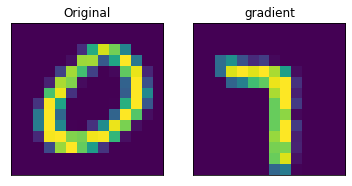

tensor([1.], grad_fn=<SelectBackward>)


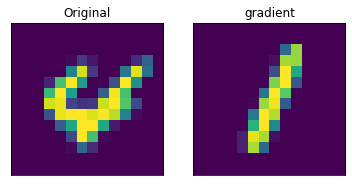

tensor([0.], grad_fn=<SelectBackward>)


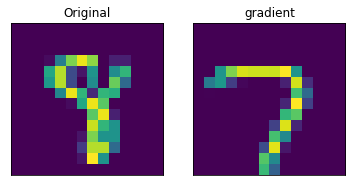

tensor([1.], grad_fn=<SelectBackward>)


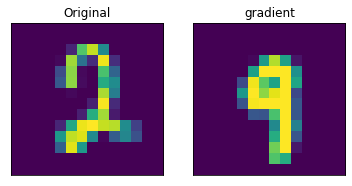

tensor([1.], grad_fn=<SelectBackward>)


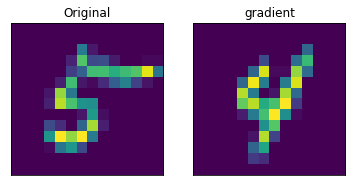

tensor([1.], grad_fn=<SelectBackward>)


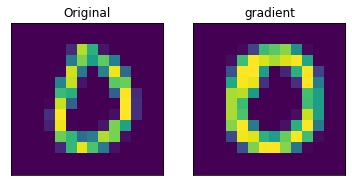

tensor([1.], grad_fn=<SelectBackward>)


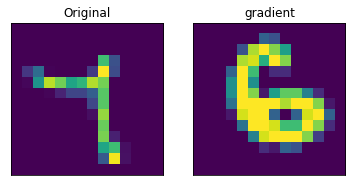

tensor([1.], grad_fn=<SelectBackward>)


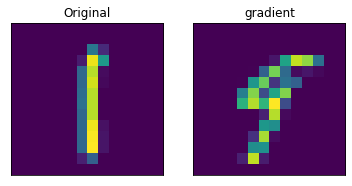

tensor([1.], grad_fn=<SelectBackward>)


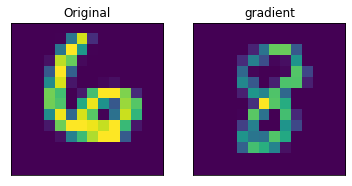

tensor([0.], grad_fn=<SelectBackward>)


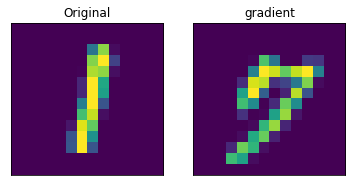

tensor([1.], grad_fn=<SelectBackward>)


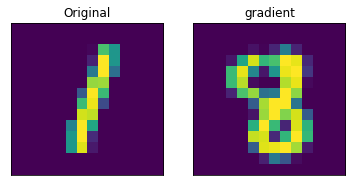

tensor([1.], grad_fn=<SelectBackward>)


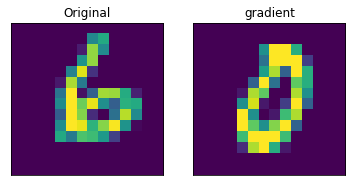

tensor([0.], grad_fn=<SelectBackward>)


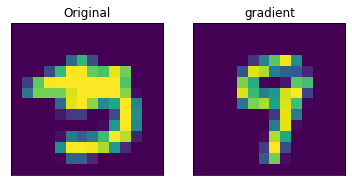

tensor([0.], grad_fn=<SelectBackward>)


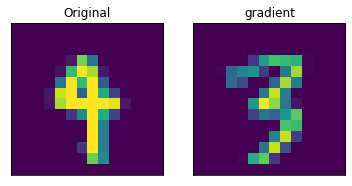

tensor([0.], grad_fn=<SelectBackward>)


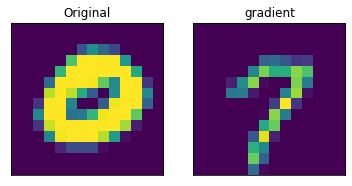

tensor([1.], grad_fn=<SelectBackward>)


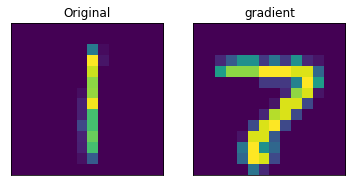

tensor([1.], grad_fn=<SelectBackward>)


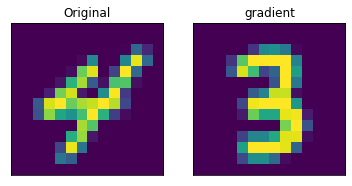

tensor([1.], grad_fn=<SelectBackward>)


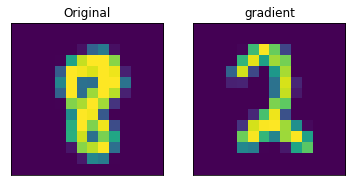

tensor([1.], grad_fn=<SelectBackward>)


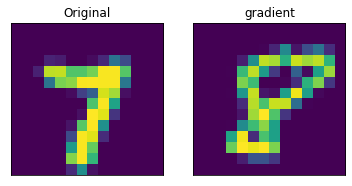

tensor([0.], grad_fn=<SelectBackward>)


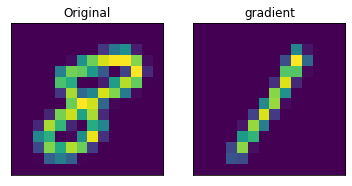

tensor([0.], grad_fn=<SelectBackward>)


In [32]:
res = net(test_input[0:20,0].reshape(20,1,14,14), test_input[0:20,1].reshape(20,1,14,14))
res[res>0.5] = 1
res[res <= 0.5] = 0
for i in range(0, 20):
    plt.subplot(121),plt.imshow(test_input[i, 0].view(14,14)),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(test_input[i, 1].view(14,14)),plt.title('gradient')
    plt.xticks([]), plt.yticks([])
    plt.show()
    print(res[i])

In [94]:
res

torch.Size([20, 1])

In [45]:
print(sum(p.numel() for p in net.parameters() if p.requires_grad))


27445
